# Distribution des naissances dans le temps 

Dans ce carnet est proposée une analyse de la distribution dans le temps des années de naissance de la population retenue, et la mise en évidence de générations.

On met aussi en évidence l'évolution dans le temps des genres

In [18]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet
from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

In [19]:
### Librairies déjà installées avec Python
import pprint
import csv
import sys

import sqlite3 as sql

import time
import datetime
from dateutil import parser

from importlib import reload
from shutil import copyfile


In [20]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf

## SPARQL Query qui récupère les données

On exécute la requête grâce à une fonction de la librairie locale qui réalise la mise en forme

In [21]:
## define SPARQL enpoint
endpoint = "https://ag1gha303ygjmx4r.allegrograph.cloud/repositories/As-de-la-Guerre"

In [26]:
query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?ace
       (SAMPLE(?label) AS ?aceLabel)
       (SAMPLE(?allegLabel) AS ?allegiance)
       (SAMPLE(?birthDate) AS ?birthDate)
       (SAMPLE(?birthYearRaw) AS ?birthYear)
       (SAMPLE(?deathDate) AS ?deathDate)
       (SAMPLE(?deathYearRaw) AS ?deathYear)
WHERE {
  GRAPH <https://github.com/samohTDNM/as-ww1/blob/main/docs/wikidata-import.md> {
    ?ace rdfs:label ?label ;
         wdt:P106 wd:Q2095549 ;
         wdt:P945 ?alleg .

    ?alleg rdfs:label ?allegLabel .

    OPTIONAL { 
      ?ace wdt:P569 ?birthDate .
      BIND(xsd:integer(SUBSTR(STR(?birthDate), 1, 4)) AS ?birthYearRaw)
    }
    OPTIONAL { 
      ?ace wdt:P570 ?deathDate .
      BIND(xsd:integer(SUBSTR(STR(?deathDate), 1, 4)) AS ?deathYearRaw)
    }
  }
}
GROUP BY ?ace
ORDER BY ?birthYear


"""

In [27]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)

In [28]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

957


[['http://www.wikidata.org/entity/Q6225085',
  'John Capper',
  'United Kingdom of Great Britain and Ireland',
  '1861-12-07T00:00:00Z',
  '1861',
  '1955-05-24T00:00:00Z',
  '1955'],
 ['http://www.wikidata.org/entity/Q3724015',
  'Emanuele Vittorio Parodi',
  'Kingdom of Italy',
  '1862-01-22T00:00:00Z',
  '1862',
  '1945-04-13T00:00:00Z',
  '1945'],
 ['http://www.wikidata.org/entity/Q57569',
  'Prince Henry of Prussia',
  'Germany',
  '1862-08-14T00:00:00Z',
  '1862',
  '1929-04-20T00:00:00Z',
  '1929']]

In [30]:
### Créer un DataFrame à partir du résultat
df_p = pd.DataFrame(r)
df_p.columns = [
    'personUri',
    'personLabel',
    'allegiance',
    'birthDate',
    'birthYear',
    'deathDate',
    'deathYear'
]
df_p.head()


,personUri,personLabel,allegiance,birthDate,birthYear,deathDate,deathYear
0,http://www.wikidata.org/entity/Q6225085,John Capper,United Kingdom of Great Britain and Ireland,1861-12-07T00:00:00Z,1861,1955-05-24T00:00:00Z,1955
1,http://www.wikidata.org/entity/Q3724015,Emanuele Vittorio Parodi,Kingdom of Italy,1862-01-22T00:00:00Z,1862,1945-04-13T00:00:00Z,1945
2,http://www.wikidata.org/entity/Q57569,Prince Henry of Prussia,Germany,1862-08-14T00:00:00Z,1862,1929-04-20T00:00:00Z,1929
3,http://www.wikidata.org/entity/Q193236,Gabriele D'Annunzio,Kingdom of Italy,1863-03-12T00:00:00Z,1863,1938-03-01T00:00:00Z,1938
4,http://www.wikidata.org/entity/Q1337203,Emile Reymond,France,1865-04-09T00:00:00Z,1865,1914-10-22T00:00:00Z,1914


In [31]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 957 entries, 0 to 956
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   personUri    957 non-null    object
 1   personLabel  957 non-null    object
 2   allegiance   957 non-null    object
 3   birthDate    957 non-null    object
 4   birthYear    957 non-null    object
 5   deathDate    957 non-null    object
 6   deathYear    957 non-null    object
dtypes: object(7)
memory usage: 52.5+ KB


### Vérifier les nationalités présentes directement sur la base de données


Voir les requêtes correspondantes dans le [SPARQL notebook qui créé la population](../../sparqlbooks/wikidata_import_population.sparqlbook)

### Ajouter une colonne au DataFrame avec l'allégeance nettoyée'

In [34]:
#on normalize
df_p['allegiance'] = df_p['allegiance'].str.strip()


In [35]:
# la fonction, voir autres notebooks
allegiance_clean_map = {
    "Kingdom of Italy": "Italy",
    "Italy": "Italy",
    "United Kingdom of Great Britain and Ireland": "United Kingdom",
    "United Kingdom": "United Kingdom",
    "British Empire": "United Kingdom",
    "Germany": "Germany",
    "German Empire": "Germany",
    "German Reich": "Germany",
    "Nazi Germany": "Germany",
    "Austria-Hungary": "Austria-Hungary",
    "Austria–Hungary": "Austria-Hungary",  # en-dash
    "Austria": "Austria-Hungary",
    "Second Polish Republic": "Poland",
    "Kingdom of Romania": "Romania",
    "Kingdom of Hungary": "Hungary",
    "Hungary": "Hungary",
    "Russian Empire": "Russia",
    "Soviet Union": "Russia",
}


In [37]:
df_p['allegiance_clean'] = df_p['allegiance'].replace(allegiance_clean_map)


In [39]:
df_p['allegiance_clean'] = df_p['allegiance'].replace(allegiance_clean_map)

df_p_allegiance_clean = df_p.groupby('allegiance_clean').size().reset_index(name='effectif')
df_p_allegiance_clean = df_p_allegiance_clean.sort_values('effectif', ascending=False)

print(df_p_allegiance_clean.head(30))



      allegiance_clean  effectif
10              France       255
31      United Kingdom       125
15               Italy       122
32       United States       118
11             Germany        86
24              Poland        63
1            Australia        44
6               Canada        35
27              Russia        30
2      Austria-Hungary        19
3              Belgium         9
21         New Zealand         7
5             Bulgaria         5
13             Hungary         4
29        South Africa         4
26             Romania         4
23      Ottoman Empire         3
14             Ireland         3
30              Sweden         2
25            Portugal         2
22              Norway         2
18  Kingdom of Prussia         2
0            Argentina         1
4               Brazil         1
7                Chile         1
8           Costa Rica         1
9       Czechoslovakia         1
17  Kingdom of Bavaria         1
16               Japan         1
12        

## Effectifs par année

In [40]:
### On inspecte les valeurs de la colonne 'birthYear' 
# et on observe que le type de données est 'object', ici texte
df_p['birthYear'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 957 entries, 0 to 956
Series name: birthYear
Non-Null Count  Dtype 
--------------  ----- 
957 non-null    object
dtypes: object(1)
memory usage: 7.6+ KB


In [41]:
### On transforme le type de valeur de la colonne BirthYear
# de objet à entier
df_p['birthYear'] = df_p['birthYear'].astype(int)

In [ ]:
### On transforme en DataFrame le résultat du regroupement par année
# noter qu'un ajoute un filtre pour que l'année maximale de naissance soit 1904
years_count = pd.DataFrame(df_p[df_p['birthYear'] < 1905].groupby('birthYear').size())\
                .reset_index(drop=False)
years_count.columns=['year','effectif']
years_count

,year,effectif
0,1861,1
1,1862,2
2,1863,1
3,1865,1
4,1866,2
5,1867,2
6,1868,2
7,1869,2
8,1870,2
9,1871,1


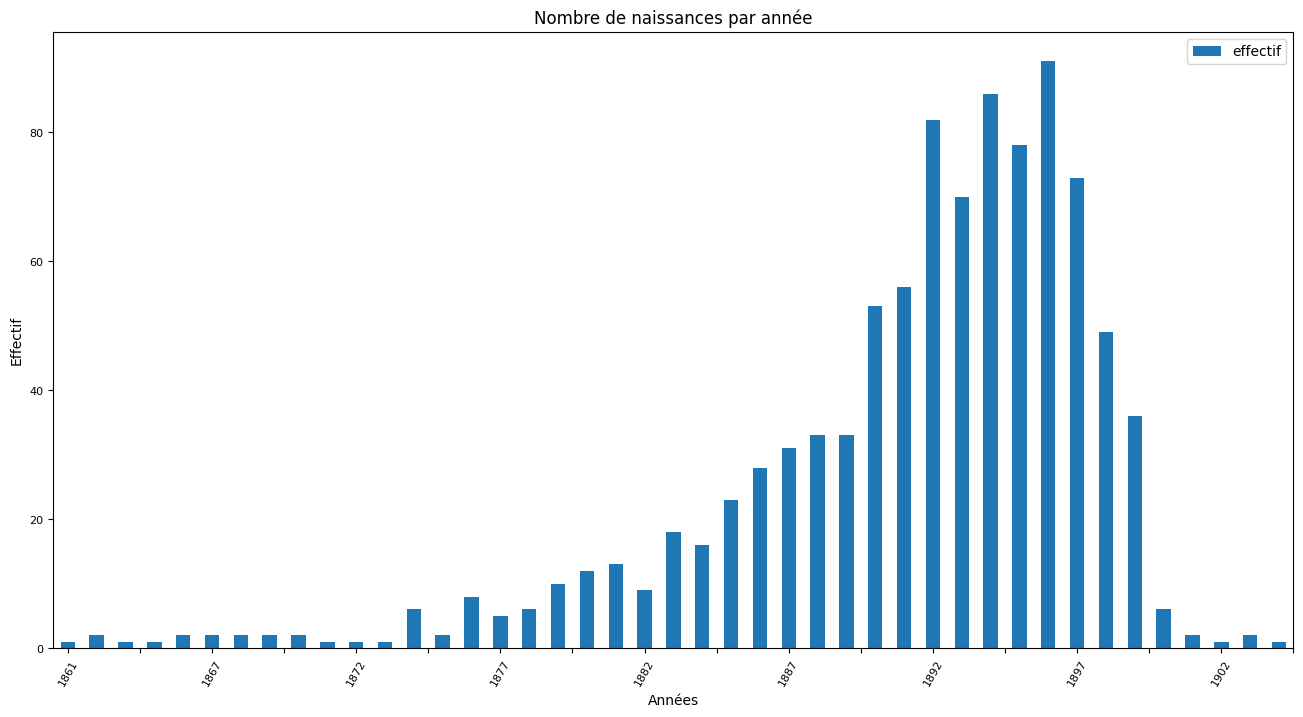

In [45]:
### Représentation graphique des effectifs par année

ax = years_count.plot(x='year', y='effectif', kind='bar',rot=60, fontsize=8, figsize=(16,8))


max_xticks = 20
xloc = plt.MaxNLocator(max_xticks)
ax.xaxis.set_major_locator(xloc)

plt.ylabel('Effectif')
plt.xlabel('Années')
plt.title('Nombre de naissances par année')
plt.show()

## Regrouper les effectifs par périodes de 5 ans

In [46]:
### Créer une copie indépendante du DataFrame (attention aux copies de variables qui sont seulement des alias) 
cdf_p = df_p[df_p['birthYear'] < 2001].copy(deep=True)

In [47]:
cdf_p.head(3)

,personUri,personLabel,allegiance,birthDate,birthYear,deathDate,deathYear,allegiance_clean
0,http://www.wikidata.org/entity/Q6225085,John Capper,United Kingdom of Great Britain and Ireland,1861-12-07T00:00:00Z,1861,1955-05-24T00:00:00Z,1955,United Kingdom
1,http://www.wikidata.org/entity/Q3724015,Emanuele Vittorio Parodi,Kingdom of Italy,1862-01-22T00:00:00Z,1862,1945-04-13T00:00:00Z,1945,Italy
2,http://www.wikidata.org/entity/Q57569,Prince Henry of Prussia,Germany,1862-08-14T00:00:00Z,1862,1929-04-20T00:00:00Z,1929,Germany


In [48]:
### Année minimale et maximale dans la population
print(min(cdf_p['birthYear']), max(cdf_p['birthYear']))

1861 1904


### Codage par période de cinq ans

In [50]:
### Créer une liste d'années pour séparer en périodes de 5 ans
# noter que la dernière année sera exclue, 
# elle donc doit être supérieure à la valeur maximale 
l_5 = list(range(1860, 1905, 5))
print(l_5[:5],l_5[-5:])

[1860, 1865, 1870, 1875, 1880] [1880, 1885, 1890, 1895, 1900]


In [51]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

cdf_p['periodes'] = pd.cut(cdf_p['birthYear'], l_5, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
cdf_p['periodes'] = cdf_p['periodes'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
cdf_p.head(3)

,personUri,personLabel,allegiance,birthDate,birthYear,deathDate,deathYear,allegiance_clean,periodes
0,http://www.wikidata.org/entity/Q6225085,John Capper,United Kingdom of Great Britain and Ireland,1861-12-07T00:00:00Z,1861,1955-05-24T00:00:00Z,1955,United Kingdom,1860-1864
1,http://www.wikidata.org/entity/Q3724015,Emanuele Vittorio Parodi,Kingdom of Italy,1862-01-22T00:00:00Z,1862,1945-04-13T00:00:00Z,1945,Italy,1860-1864
2,http://www.wikidata.org/entity/Q57569,Prince Henry of Prussia,Germany,1862-08-14T00:00:00Z,1862,1929-04-20T00:00:00Z,1929,Germany,1860-1864


In [52]:
### compter les naissances par périodes de 5 ans
cdf_p.groupby(by='periodes').size()

C:\Users\menou\AppData\Local\Temp\ipykernel_27980\1755115692.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cdf_p.groupby(by='periodes').size()


periodes
1860-1864      4
1865-1869      9
1870-1874     11
1875-1879     31
1880-1884     68
1885-1889    148
1890-1894    347
1895-1899    327
dtype: int64

C:\Users\menou\AppData\Local\Temp\ipykernel_27980\3694462858.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ax = cdf_p.groupby(by='periodes').size().plot(kind='bar',rot=60, fontsize=8, figsize=(16,8))


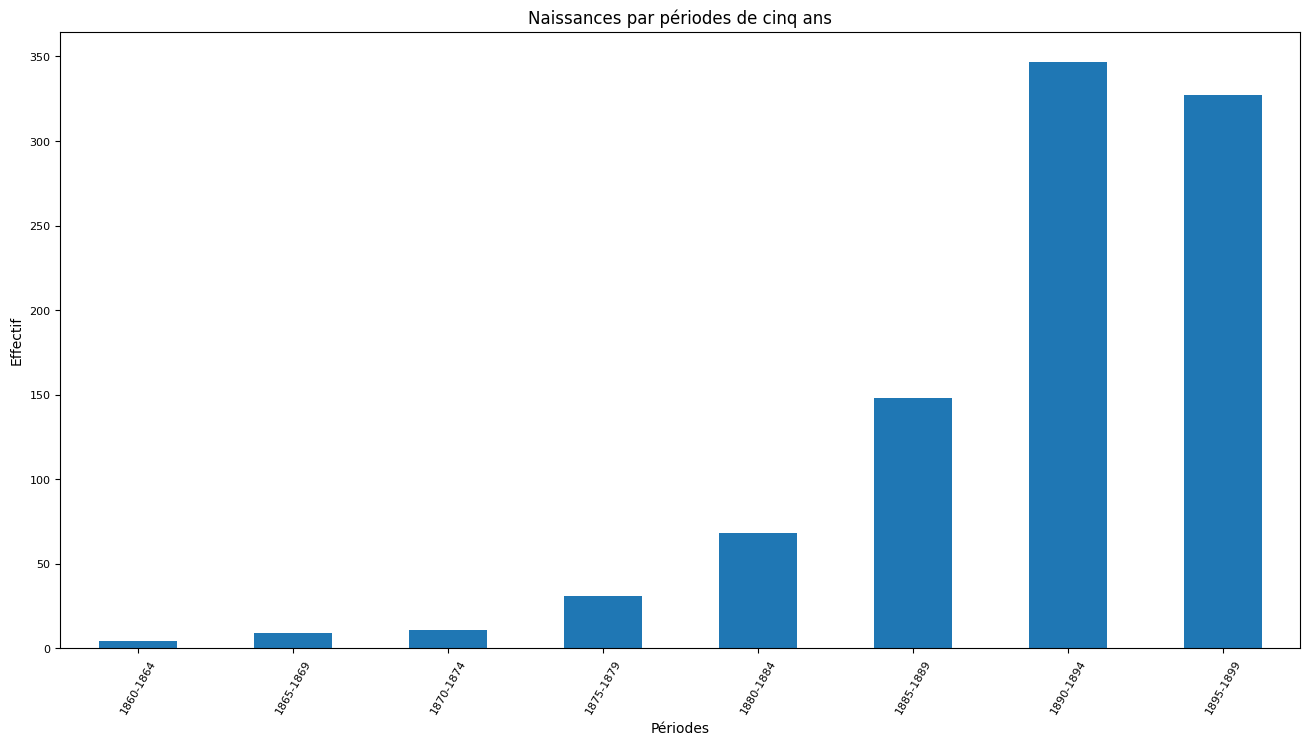

In [53]:
ax = cdf_p.groupby(by='periodes').size().plot(kind='bar',rot=60, fontsize=8, figsize=(16,8))
plt.ylabel('Effectif')
plt.xlabel('Périodes')
plt.title('Naissances par périodes de cinq ans')
plt.show()

## Ajouter la représentation des nationalités

In [ ]:
### Regrouper et compter les effectifs
top10_allegiances = (
    cdf_p.groupby('allegiance_clean')
         .size()
         .reset_index(name='effectif')
         .sort_values('effectif', ascending=False)
         .head(10)
)

print(top10_allegiances)

In [54]:
### Regrouper et compter avec un fitre sur la nationalité française (FR)
country_fr = pd.DataFrame(cdf_p[cdf_p['allegiance_clean'] == 'France'].groupby('periodes').size())
country_fr.columns = ['country_fr']
country_fr.tail()



C:\Users\menou\AppData\Local\Temp\ipykernel_27980\3285687334.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  country_fr = pd.DataFrame(cdf_p[cdf_p['allegiance_clean'] == 'France'].groupby('periodes').size())


,country_fr
periodes,
1875-1879,16
1880-1884,32
1885-1889,47
1890-1894,89
1895-1899,59


In [56]:
# on définit les alliances
def code_alliances(allegiance_clean):
    # Allies during WW1
    allies = {
        "France", "Italy", "United States", "United Kingdom",
        "Australia", "Canada", "New Zealand", "Belgium",
        "Russian Empire", "Russia", "South Africa", "Ireland",
        "Portugal", "Romania", "Serbia"
    }

    # Central Powers during WW1
    central_powers = {
        "Germany", "German Empire", "German Reich", "Nazi Germany",
        "Austria-Hungary", "Austria", "Bulgaria", "Ottoman Empire",
        "Kingdom of Saxony", "Kingdom of Prussia", "Hungary", "Kingdom of Bavaria"
    }

    if allegiance_clean in allies:
        return "Allies"
    elif allegiance_clean in central_powers:
        return "Central Powers"
    else:
        return "Other"

In [57]:
cdf_p['alliance'] = cdf_p['allegiance_clean'].apply(code_alliances)


In [ ]:
# on regarde la distribution

alliance_counts = (
    cdf_p['alliance']
    .value_counts()
    .reset_index(name='effectif')
    .rename(columns={'index': 'alliance'})
)

print(alliance_counts)


         alliance  effectif
0          Allies       759
1  Central Powers       121
2           Other        77


In [62]:
# Group by birth decade and alliance
cdf_p['periodes'] = (cdf_p['birthYear'] // 5) * 5

merged = (
    cdf_p.groupby(['periodes', 'alliance'])
    .size()
    .unstack(fill_value=0)
)

merged.index = merged.index.map(str)


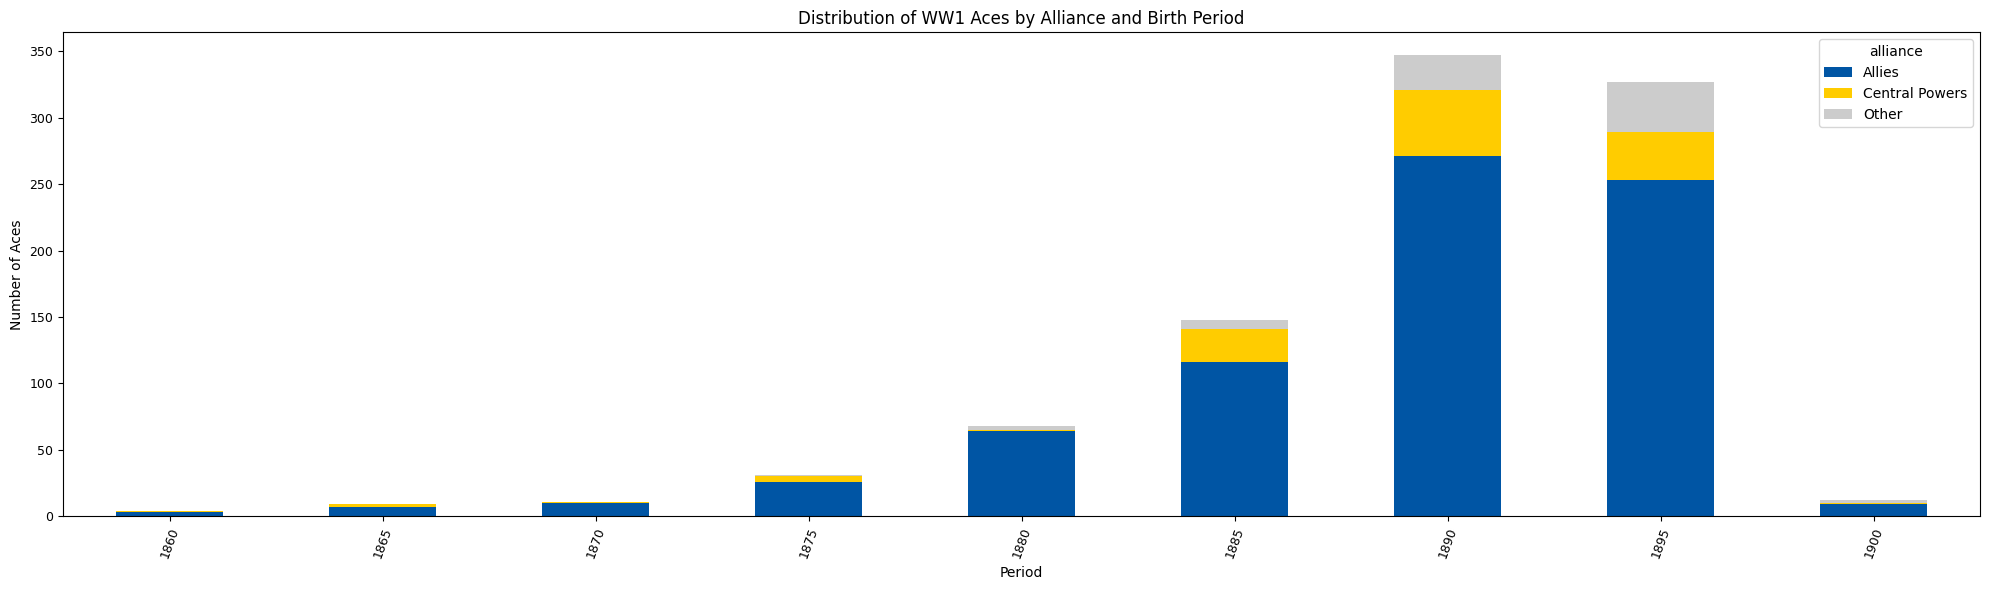

In [65]:
### Documentation
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html
ax = merged.plot.bar(
    stacked=True,
    rot=70,
    fontsize=9,
    figsize=(20, 6),
    color=['#0055A4', '#FFCC00', '#CCCCCC'] 
)
plt.title("Distribution of WW1 Aces by Alliance and Birth Period")
plt.xlabel("Period")
plt.ylabel("Number of Aces")
plt.tight_layout()
plt.show()

### Codage par période de deux ans

Comme on voit bien dans le graphique précédent qu'il y a une période avec des effectifs importants, 
on restraint la période analysée et on affine avec un découpage par périodes de deux ans 

In [72]:
l_2 = list(range(1860, 1900, 2))
print(l_2[:5],l_2[-5:])

[1860, 1862, 1864, 1866, 1868] [1890, 1892, 1894, 1896, 1898]


In [73]:
### Découpage tous les deux ans
# fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html

cdf_p['per_2'] = pd.cut(cdf_p['birthYear'], l_2, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
cdf_p['per_2'] = cdf_p['per_2'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
cdf_p.head(3)

,personUri,personLabel,allegiance,birthDate,birthYear,deathDate,deathYear,allegiance_clean,periodes,alliance,per_2
0,http://www.wikidata.org/entity/Q6225085,John Capper,United Kingdom of Great Britain and Ireland,1861-12-07T00:00:00Z,1861,1955-05-24T00:00:00Z,1955,United Kingdom,1860,Allies,1860-1861
1,http://www.wikidata.org/entity/Q3724015,Emanuele Vittorio Parodi,Kingdom of Italy,1862-01-22T00:00:00Z,1862,1945-04-13T00:00:00Z,1945,Italy,1860,Allies,1862-1863
2,http://www.wikidata.org/entity/Q57569,Prince Henry of Prussia,Germany,1862-08-14T00:00:00Z,1862,1929-04-20T00:00:00Z,1929,Germany,1860,Central Powers,1862-1863


In [ ]:
### On regroupe par nationalité comme ci-dessus

allies_2 = pd.DataFrame(
    cdf_p[(cdf_p['alliance'] == 'Allies') & (cdf_p['birthYear'] > 1850)]
    .groupby('per_2')
    .size()
)
allies_2.columns = ['Allies']

allies_2.tail()


C:\Users\menou\AppData\Local\Temp\ipykernel_27980\3802819244.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('per_2')


,Allies
per_2,
1888-1889,52
1890-1891,81
1892-1893,116
1894-1895,133
1896-1897,125


In [78]:
### Idem
central_2 = pd.DataFrame(
    cdf_p[(cdf_p['alliance'] == 'Central Powers') & (cdf_p['birthYear'] > 1850)]
    .groupby('per_2')
    .size()
)
central_2.columns = ['Central Powers']

central_2.tail()


C:\Users\menou\AppData\Local\Temp\ipykernel_27980\354149380.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('per_2')


,Central Powers
per_2,
1888-1889,10
1890-1891,21
1892-1893,23
1894-1895,16
1896-1897,19


In [79]:
other_2 = pd.DataFrame(
    cdf_p[(cdf_p['alliance'] == 'Other') & (cdf_p['birthYear'] > 1850)]
    .groupby('per_2')
    .size()
)
other_2.columns = ['Other']

other_2.tail()

C:\Users\menou\AppData\Local\Temp\ipykernel_27980\2078097046.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('per_2')


,Other
per_2,
1888-1889,4
1890-1891,7
1892-1893,13
1894-1895,15
1896-1897,20


In [81]:
merged_2 = pd.concat([allies_2, central_2, other_2], axis=1).fillna(0)

merged_2.tail()

,Allies,Central Powers,Other
per_2,,,
1888-1889,52,10,4
1890-1891,81,21,7
1892-1893,116,23,13
1894-1895,133,16,15
1896-1897,125,19,20


In [ ]:
### On transforme le type de valeur de l'index
# et on ajoute une colonne avec le total
merged_2.index = merged_2.index.map(str)

merged_2['tot'] = merged_2['Allies'] + merged_2['Central Powers'] + merged_2['Other']
merged_2.tail()

,Allies,Central Powers,Other,tot
per_2,,,,
1888-1889,52,10,4,66
1890-1891,81,21,7,109
1892-1893,116,23,13,152
1894-1895,133,16,15,164
1896-1897,125,19,20,164


In [ ]:
### On prépare les valeurs pour l'affichage des fréquences (proportion par rapport au total)

# on regroupe les valeurs
alliances_flat = (
    merged_2['Allies'].tolist() +
    merged_2['Central Powers'].tolist() +
    merged_2['Other'].tolist()
)

totals = merged_2['tot'].tolist() * 3


lp = [round(v / t, 2) if t > 0 else 0 for v, t in zip(alliances_flat, totals)]


print(lp[:6])  

[1.0, 0.67, 1.0, 0.5, 1.0, 1.0]


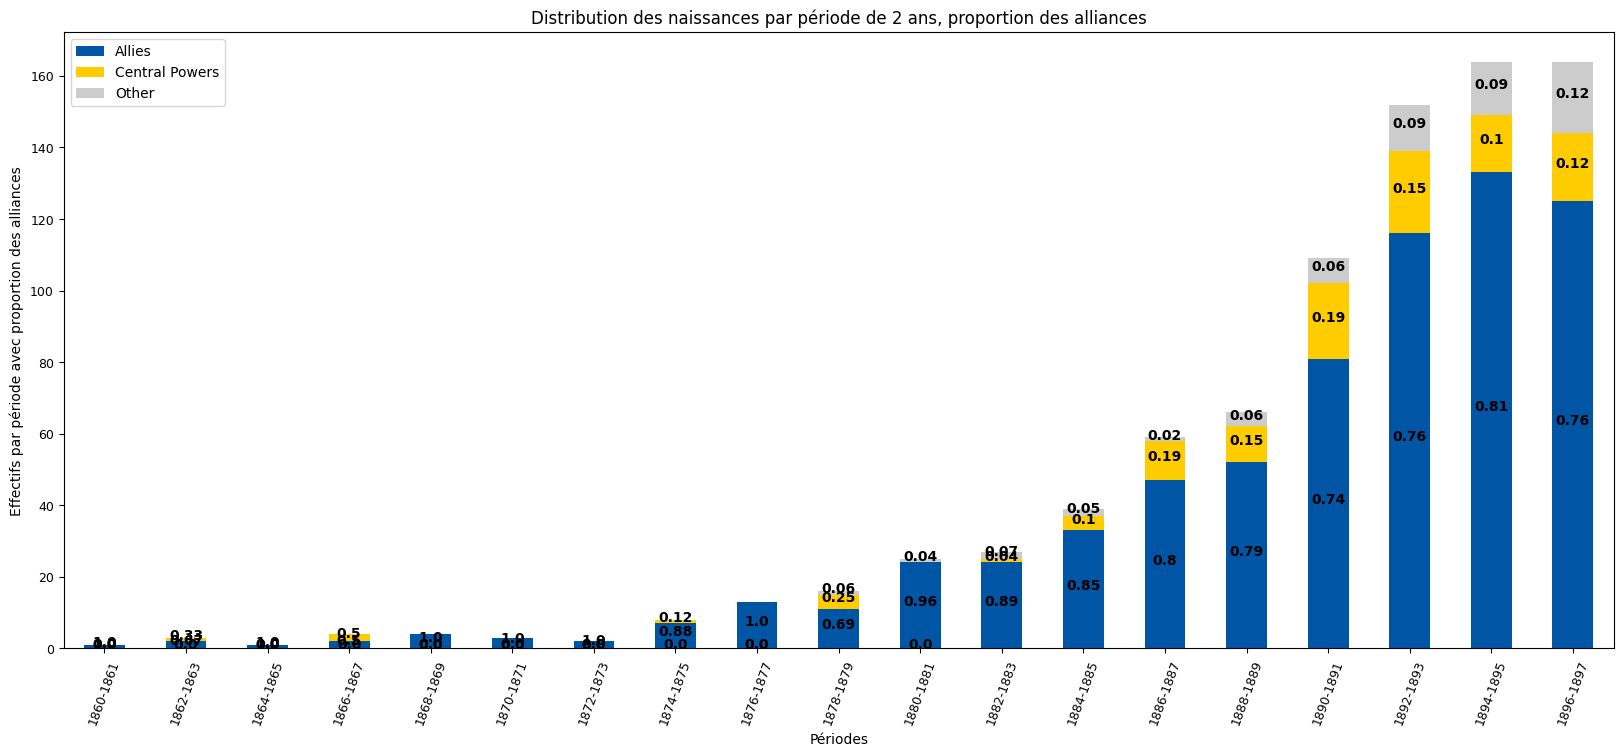

In [87]:
### Graphique avec la distribution (proportion) par période de deux ans et pays

ax = merged_2.plot.bar(
    stacked=True,
    y=['Allies', 'Central Powers', 'Other'],
    rot=70,
    fontsize=9,
    figsize=(20, 8),
    color=['#0055A4', '#FFCC00', '#CCCCCC']  
)

for bar, v in zip(ax.patches, lp): 
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_y() + bar.get_height() / 2,
        v,
        ha='center',
        color='black',
        weight='bold',
        size=10
    )

plt.ylabel('Effectifs par période avec proportion des alliances')
plt.xlabel('Périodes')
plt.title("Distribution des naissances par période de 2 ans, proportion des alliances")


## On peut enregistrer l'image dans un fichier (noter le dossier créé préalablement)
# qu'on pourra ensuite introduire dans un travail et commenter

# Doc.: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html
plt.savefig('naissances_distribution_2ans_pays.jpg', bbox_inches='tight', pad_inches=0.2)
plt.show()

## Analyse des données

In [88]:
# on veut comparer les proportions des trois dernières périodes par rapport aux autres
last_3 = merged_2.tail(3)
last_3_total = last_3['tot'].sum()

In [89]:
rest = merged_2.iloc[:-3]
rest_total = rest['tot'].sum()

In [90]:
total_all = last_3_total + rest_total

last_3_prop = round(last_3_total / total_all, 2)
rest_prop = round(rest_total / total_all, 2)


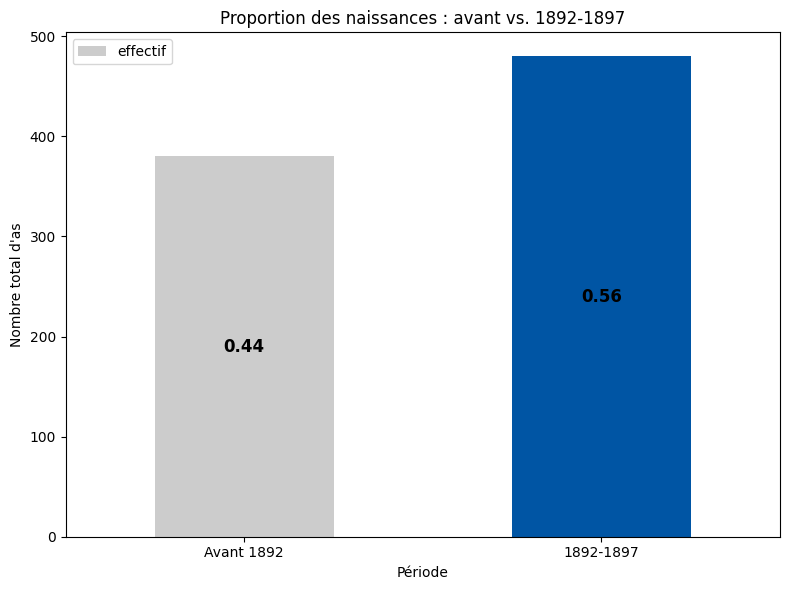

In [95]:
compare_df = pd.DataFrame({
    'période': ['Avant 1892', '1892-1897'],
    'effectif': [rest_total, last_3_total]
})

ax = compare_df.plot.bar(
    x='période',
    y='effectif',
    color=['#CCCCCC', '#0055A4'],
    rot=0,
    figsize=(8, 6)
)

total_all = rest_total + last_3_total
props = [round(rest_total / total_all, 2), round(last_3_total / total_all, 2)]

for bar, prop in zip(ax.patches, props):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() / 2,
        f"{prop}",
        ha='center',
        va='center',
        color='black',
        weight='bold',
        size=12
    )

plt.title("Proportion des naissances : avant vs. 1892-1897")
plt.xlabel("Période")
plt.ylabel("Nombre total d'as")
plt.tight_layout()
plt.show()



In [98]:
# On compte combien de période les deux catégories comprennent
num_rest_periods = len(merged_2.iloc[:-3])
num_last_periods = len(merged_2.tail(3))


print(f"Le groupe 'Avant 1892' comprend {num_rest_periods} périodes de 2 ans et équivaut à 44%.")
print(f"Le groupe '1892–1897' comprend {num_last_periods} périodes de 2 ans et équivaut à 56%.")


Le groupe 'Avant 1892' comprend 16 périodes de 2 ans et équivaut à 44%.
Le groupe '1892–1897' comprend 3 périodes de 2 ans et équivaut à 56%.
